# NDVI Time Series (2014–2018): PROBA-V + Sentinel-3-LFR

## 📌 Objectives

- Build a harmonized NDVI series over **Limuru**
- Combine **PROBA-V NDVI (2014–2017)** with **Sentinel-3 LFR (Land Full Resolution, 2017–2018)**
- Use reflectance bands from LFR `.nc` files for NDVI computation
- Integrate and compare NDVI derived from both **Sentinel-3 LFR (local Level 2)** and **Sentinel-3 OLCI (cloud-based Level 1)** data
- Apply radiance scaling to Sentinel-3 OLCI radiance bands to compute NDVI
- Compare and analyze NDVI outputs from four different processing routes across varying time ranges

## 🛰️ Datasets Used

### 1. **PROBA-V NDVI**
- **Source**: [VITO/PROBAV/C1/S1_TOC_333M](https://developers.google.com/earth-engine/datasets/catalog/VITO_PROBAV_C1_S1_TOC_333M)
- **Period**: 2014–2017
- **Spatial Resolution**: 333m
- **Processing**: GEE-based monthly composites using `.select('NDVI')`

### 2. **Sentinel-3 LFR (Local Level 2)**
- **Product**: `rc_gifapar.nc` file inside zipped `.SEN3` directories
- **Bands Used**:
  - `RC681` (Red)
  - `RC865` (NIR)
- **Period**: 2017–2018
- **Processing**:
  - NDVI = (RC865 - RC681) / (RC865 + RC681)
  - NDVI calculated per file and stacked by date

### 3. **Sentinel-3 OLCI (Cloud-Based Radiance)**
- **Source**: Copernicus OLCI L1 Radiance products via GEE or direct access
- **Bands Used**:
  - Radiance bands mapped to RED and NIR
- **Processing**:
  - Radiance values scaled to reflectance
  - NDVI derived post-scaling and temporally aligned with other sources

## 🛠️ Tools & Libraries

- Google Earth Engine Python API
- `xarray`, `numpy`, `matplotlib`, `scipy`, `pandas`, `glob`, `zipfile`
- `scipy.interpolate` and rolling filters for temporal smoothing and gap-filling
- `matplotlib` for multi-series NDVI visualization across data sources

## ⚙️ Workflow Highlights

- Harmonized NDVI time series constructed from multi-sensor input
- Temporal smoothing applied to handle missing values and ensure consistency across months
- Sentinel-3 NDVI computed from both reflectance (LFR) and radiance-scaled (Level 1) data
- All NDVI results plotted side-by-side to analyze consistency, divergence, and temporal dynamics across sources

In [28]:
# Install required packages (run only once)
!pip install earthengine-api geemap xarray matplotlib numpy scipy ipywidgets tqdm pillow gdown


# Initialization and PROBA-V NDVI from Google Earth Engine

In [21]:
import ee
import geemap
import os
import zipfile
import glob
import re
import imageio
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from tqdm import tqdm
from scipy.signal import savgol_filter

print("✅ Process complete!")


✅ Process complete!


# Initialize Earth Engine and Load AOI

In [3]:
try:
    ee.Initialize()
except Exception as e:
    print(f"Earth Engine initialization failed: {e}")
    print("Attempting to authenticate...")
    ee.Authenticate()
    ee.Initialize()

# Create interactive map object
Map = geemap.Map()

# Load AOI (replace with your actual asset path if needed)
aoi = ee.FeatureCollection("projects/ee-ongetewesly1/assets/limuru")

# Visualize AOI on the map
Map.centerObject(aoi, 12)
Map.addLayer(aoi.style(**{'color': 'black', 'fillColor': '00000000'}), {}, 'Limuru')

print(f"AOI 'Limuru' loaded and added to the map.")
Map

AOI 'Limuru' loaded and added to the map.


Map(center=[-1.0996769665355406, 36.68849098122006], controls=(WidgetControl(options=['position', 'transparent…

# Monthly Composite function

In [4]:
# Monthly composite function
def monthly_composite(collection, start, end):
    months = ee.List.sequence(0, ee.Date(end).difference(ee.Date(start), 'month').subtract(1))
    
    def create_monthly_image(m):
        m = ee.Number(m)
        start_date = ee.Date(start).advance(m, 'month')
        end_date = start_date.advance(1, 'month')
        monthly = collection.filterDate(start_date, end_date).median()
        return monthly.set('system:time_start', start_date.millis()).clip(aoi)
    
    return ee.ImageCollection.fromImages(months.map(create_monthly_image))


# Fortnightly Composite function

In [5]:
# Fortnightly composite function
# Fixed-interval fortnightly composite function (1–15 and 16–28 for each month)
def fortnightly_composite(collection, start, end):
    start_date = ee.Date(start)
    end_date = ee.Date(end)
    n_months = end_date.difference(start_date, 'month').floor()
    months = ee.List.sequence(0, n_months.subtract(1))

    def create_fortnights(m):
        m = ee.Number(m)
        month_start = start_date.advance(m, 'month')
        
        # First half: 1st to 15th
        first_start = month_start
        first_end = month_start.advance(15, 'day')
        first_half = (collection.filterDate(first_start, first_end)
                                  .median()
                                  .set('system:time_start', first_start.millis())
                                  .clip(aoi))

        # Second half: 16th to 28th (fixed to avoid end-of-month issues)
        second_start = month_start.advance(15, 'day')
        second_end = month_start.advance(28, 'day')
        second_half = (collection.filterDate(second_start, second_end)
                                   .median()
                                   .set('system:time_start', second_start.millis())
                                   .clip(aoi))

        return ee.List([first_half, second_half])
    
    all_fortnights = months.map(create_fortnights).flatten()
    return ee.ImageCollection.fromImages(all_fortnights)

# Load PROBA-V and Generate Monthly and Fortnightly Composites

In [6]:
# Load and scale PROBA-V NDVI
proba_start = "2014-01-01"
proba_end = "2017-12-31"
probaV = ee.ImageCollection("VITO/PROBAV/C1/S1_TOC_333M") \
    .filterDate(proba_start, proba_end) \
    .filterBounds(aoi) \
    .map(lambda img: img.select("NDVI")
        .updateMask(img.select("NDVI").neq(0).And(img.select("NDVI").neq(250)))
        .subtract(20).divide(250).rename("ndvi")
        .copyProperties(img, ["system:time_start"])
    )

# Generate monthly composites
probaV_monthly = monthly_composite(probaV, proba_start, proba_end)
print("✅ PROBA-V loading and monthly compositing complete!")

# Generate fortnightly composites
probaV_fortnite = fortnightly_composite(probaV, proba_start, proba_end)
print("✅ PROBA-V loading and fortnite compositing complete!")

# Create a sample median composite for quick visual confirmation
probaV_sample = probaV_monthly.filterDate(proba_start, "2014-01-30").median()

# Set NDVI visualization parameters
vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['orange', 'yellow', 'green']
}

# Display the sample image
Map.centerObject(aoi, 12)
Map.addLayer(probaV_sample, vis_params, 'ProbaV Sample image')
print("🟢 Displaying sample median NDVI image")



✅ PROBA-V loading and monthly compositing complete!
✅ PROBA-V loading and fortnite compositing complete!
🟢 Displaying sample median NDVI image


# Extract Monthly NDVI Values from PROBA-V

In [7]:
# Get PROBA-V NDVI values from manually created composites
proba_dates, proba_ndvis = [], []

# Get number of monthly composites
n_images = probaV_monthly.size().getInfo()
print(f"🧮 Total monthly PROBA-V images: {n_images}")

#  Number of extracted data to preview
n_preview = 5  # change as needed

for i in range(n_images):
    image = ee.Image(probaV_monthly.toList(n_images).get(i))
    
    # Extract timestamp and convert to datetime
    timestamp = image.get('system:time_start').getInfo()
    date = datetime.utcfromtimestamp(timestamp / 1000)
    proba_dates.append(date)
    
    # Reduce NDVI over AOI
    stat = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi.geometry(),
        scale=333,
        maxPixels=1e13
    ).getInfo()
    
    ndvi = stat.get('ndvi', None)
    proba_ndvis.append(ndvi if ndvi is not None else np.nan)

    # Print preview for first few
    if i < n_preview:
        print(f"📅 {date.date()} — NDVI: {ndvi if ndvi is not None else 'Missing'}")

print("✅ Finished extracting PROBA-V Monthly NDVI stats.")


🧮 Total monthly PROBA-V images: 47
📅 2014-01-01 — NDVI: 0.7502349657253535
📅 2014-02-01 — NDVI: 0.5582446314305843
📅 2014-03-01 — NDVI: 0.6206772024839331
📅 2014-04-01 — NDVI: 0.6689594204848361
📅 2014-05-01 — NDVI: 0.11736862199198075
✅ Finished extracting PROBA-V Monthly NDVI stats.


# Extract Fortnightly NDVI Values from PROBA-V

In [8]:
# Get PROBA-V fortnightly NDVI values from manually created composites
proba_dates_fortnite, proba_ndvis_fortnite = [], []

# Get number of fortnightly composites
n_images = probaV_fortnite.size().getInfo()
print(f"🧮 Total fortnightly PROBA-V images: {n_images}")

#  Number of extracted data to preview
n_preview = 5  # change as needed

for i in range(n_images):
    image = ee.Image(probaV_fortnite.toList(n_images).get(i))
    
    # Extract timestamp and convert to datetime
    timestamp = image.get('system:time_start').getInfo()
    date = datetime.utcfromtimestamp(timestamp / 1000)
    proba_dates_fortnite.append(date)
    
    # Reduce NDVI over AOI
    stat = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi.geometry(),
        scale=333,
        maxPixels=1e13
    ).getInfo()
    
    ndvi = stat.get('ndvi', None)
    proba_ndvis_fortnite.append(ndvi if ndvi is not None else np.nan)

    # Print preview for first few
    if i < n_preview:
        print(f"📅 {date.date()} — NDVI: {ndvi if ndvi is not None else 'Missing'}")

print("✅ Finished extracting Fortnightly PROBA-V NDVI stats.")


🧮 Total fortnightly PROBA-V images: 94
📅 2014-01-01 — NDVI: 0.7543867914588274
📅 2014-01-16 — NDVI: 0.73119530305079
📅 2014-02-01 — NDVI: 0.631414611582067
📅 2014-02-16 — NDVI: 0.4363533795688465
📅 2014-03-01 — NDVI: 0.7217316983115084
✅ Finished extracting Fortnightly PROBA-V NDVI stats.


# Cloud-processed Sentinel-3 NDVI (scaled radiance method)
## Monthly and Fortnightly Composites

In [9]:
# Extract Fortnightly NDVI statistics from Sentinel-3 monthly composites
def process_cloud_s3(img):
    scale_17 = ee.Number(img.get('Oa17_radiance_scale'))
    scale_08 = ee.Number(img.get('Oa08_radiance_scale'))
    scaled = img.select(['Oa17_radiance', 'Oa08_radiance']) \
                .divide(ee.Image.constant([scale_17, scale_08]))
    ndvi = scaled.normalizedDifference(['Oa17_radiance', 'Oa08_radiance']) \
                .rename('ndvi') \
                .reproject('EPSG:4326', None, 300)
    return ndvi.copyProperties(img, ['system:time_start'])

# Filter and process Sentinel-3 collection
s3_start = "2017-01-01"
s3_end = "2018-12-31"
s3_cloud = (
    ee.ImageCollection("COPERNICUS/S3/OLCI")
    .filterDate(s3_start, s3_end)
    .filterBounds(aoi)
    .filter(
        ee.Filter.And(
            ee.Filter.notNull(['Oa17_radiance_scale']),
            ee.Filter.notNull(['Oa08_radiance_scale'])
        )
    )
    .map(process_cloud_s3)
)


# Monthly composites from cloud-processed Sentinel-3
s3_cloud_monthly = monthly_composite(s3_cloud, s3_start, s3_end)
print("✅ S3 loading and monthly compositing complete!")

# Fortnightly composites from cloud-processed Sentinel-3
s3_cloud_fortnite = fortnightly_composite(s3_cloud, s3_start, s3_end)
print("✅ S3 loading and fortnightly compositing complete!")

# Create a sample median composite for quick visual confirmation
S3_cloud_sample = probaV_monthly.filterDate(s3_start, "2017-01-30").median()

# Set NDVI visualization parameters
vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['orange', 'yellow', 'green']
}

# Display the sample image
Map.centerObject(aoi, 12)
Map.addLayer(S3_cloud_sample, vis_params, 'S3_cloud Sample image')
print("🟢 Displaying sample median NDVI image")

✅ S3 loading and monthly compositing complete!
✅ S3 loading and fortnightly compositing complete!
🟢 Displaying sample median NDVI image


# Extracting Monthly NDVI Values from Cloud Processed Sentinel-3 Composites


In [10]:
# Extract Monthly NDVI statistics from Sentinel-3 monthly composites
# Map over the image collection to extract mean NDVI and timestamp as Features
s3_ndvi_fc = s3_cloud_monthly.map(
    lambda img: ee.Feature(None, {
        'ndvi': img.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=aoi.geometry(),
            scale=300,
            maxPixels=1e13
        ).get('ndvi'),
        'time': img.get('system:time_start')
    })
)

# Convert FeatureCollection to a list and fetch client-side
features = s3_ndvi_fc.toList(s3_ndvi_fc.size()).getInfo()

# Parse features
cloud_dates, cloud_ndvis = [], []
for feat in features:
    props = feat.get('properties', {})
    timestamp = props.get('time')
    ndvi = props.get('ndvi')

    if timestamp is not None:
        date = datetime.utcfromtimestamp(timestamp / 1000)
        cloud_dates.append(date)
        cloud_ndvis.append(ndvi if ndvi is not None else np.nan)

# Preview first few
n_preview = 5
for i in range(min(n_preview, len(cloud_dates))):
    print(f"📅 {cloud_dates[i].date()} — NDVI: {cloud_ndvis[i]}")

# Final summary
print(f"✅ Finished extracting Sentinel-3 Monthly NDVI stats.")
print(f"📦 Total records parsed: {len(cloud_dates)} dates and {len(cloud_ndvis)} NDVI values.")

📅 2017-01-01 — NDVI: 0.7024665926217992
📅 2017-02-01 — NDVI: 0.6725537657560228
📅 2017-03-01 — NDVI: 0.5958913669314924
📅 2017-04-01 — NDVI: 0.2568627392939948
📅 2017-05-01 — NDVI: 0.18879381327509678
✅ Finished extracting Sentinel-3 Monthly NDVI stats.
📦 Total records parsed: 23 dates and 23 NDVI values.


# Extracting Fortnightly NDVI Values from Cloud Processed Sentinel-3 Composites


In [11]:
# Extract Fortnightly NDVI statistics from Sentinel-3 monthly composites
# Map over the image collection to extract mean NDVI and timestamp as Features
s3_ndvi_fc_fortnite = s3_cloud_fortnite.map(
    lambda img: ee.Feature(None, {
        'ndvi': img.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=aoi.geometry(),
            scale=300,
            maxPixels=1e13
        ).get('ndvi'),
        'time': img.get('system:time_start')
    })
)

# Convert FeatureCollection to a list and fetch client-side
features = s3_ndvi_fc_fortnite.toList(s3_ndvi_fc_fortnite.size()).getInfo()

# Parse features
cloud_dates_fortnite, cloud_ndvis_fortnite = [], []
for feat in features:
    props = feat.get('properties', {})
    timestamp = props.get('time')
    ndvi = props.get('ndvi')

    if timestamp is not None:
        date = datetime.utcfromtimestamp(timestamp / 1000)
        cloud_dates_fortnite.append(date)
        cloud_ndvis_fortnite.append(ndvi if ndvi is not None else np.nan)

# Preview first few
n_preview = 5
for i in range(min(n_preview, len(cloud_dates_fortnite))):
    print(f"📅 {cloud_dates_fortnite[i].date()} — NDVI: {cloud_ndvis_fortnite[i]}")

# Final summary
print(f"✅ Finished extracting Sentinel-3 Fortnightly NDVI stats.")
print(f"📦 Total records parsed: {len(cloud_dates_fortnite)} dates and {len(cloud_ndvis_fortnite)} NDVI values.")

📅 2017-01-01 — NDVI: 0.7396242343097624
📅 2017-01-16 — NDVI: 0.6724330708153561
📅 2017-02-01 — NDVI: 0.6940214274755812
📅 2017-02-16 — NDVI: 0.5915964339731694
📅 2017-03-01 — NDVI: 0.6577912493231167
✅ Finished extracting Sentinel-3 Fortnightly NDVI stats.
📦 Total records parsed: 46 dates and 46 NDVI values.


# Extracting Sentinel-3 NDVI from Local Zipped .SEN3 Files (LFR)

In [20]:
# Sentinel-3 NDVI from Local Zipped .SEN3 Files (LFR)
# Configuration
zip_folder = "F:/Sentinel Data Library/S3_OL_2_LFR/"  # Your folder path
nc_file = "rc_gifapar.nc"

# Initialize lists
local_dates, local_ndvis = [], []

# Count and Print Trackers
zip_count = 0
nc_found_count = 0
print_limit = 5
printed = 0

# Start processing
for zip_path in sorted(glob.glob(os.path.join(zip_folder, "*.zip"))):
    zip_count += 1
    try:
        with zipfile.ZipFile(zip_path, 'r') as zf:
            nc_in_zip = [f for f in zf.namelist() if f.endswith(nc_file)]
            if not nc_in_zip:
                continue  # Skip if nc file not present
            nc_found_count += 1
            with zf.open(nc_in_zip[0]) as f:
                ds = xr.open_dataset(f)

                if "RC681" not in ds.variables or "RC865" not in ds.variables:
                    print(f"❌ Missing RC bands in {zip_path}")
                    continue

                red = ds["RC681"].values.astype(np.float32)
                nir = ds["RC865"].values.astype(np.float32)

                ndvi = (nir - red) / (nir + red)
                ndvi = np.where((nir + red) == 0, np.nan, ndvi)
                ndvi_mean = np.nanmean(ndvi)

                local_ndvis.append(ndvi_mean)

                # Extract date and time from filename using split on '____'
                filename = os.path.basename(zip_path)
                parts = filename.split('____')
                if len(parts) > 1:
                    datetime_section = parts[1]
                    # Extract the first datetime (YYYYMMDDTHHMMSS) using regex
                    match = re.match(r'(\d{8}T\d{6})', datetime_section)
                    if match:
                        datetime_str = match.group(1)  # e.g. '20170103T073631'
                        observation_datetime = datetime.strptime(datetime_str, "%Y%m%dT%H%M%S")
                        local_dates.append(observation_datetime)

                        # Print the first 5 extracted values
                        if printed < print_limit:
                            print(f"📅 {observation_datetime.strftime('%Y-%m-%d')} — NDVI: {ndvi_mean}")
                            printed += 1
                    else:
                        print(f"⚠️ Could not extract datetime from datetime section in {filename}")
                        continue
                else:
                    print(f"⚠️ Unexpected filename format: {filename}")
                    continue

    except Exception as e:
        print(f"⚠️ Error reading {zip_path}: {e}")
        continue

# Final confirmation
print("✅ Process complete!")
print(f"📦 ZIP files found: {zip_count}")
print(f"📂 ZIPs with '{nc_file}': {nc_found_count}")
print(f"📈 Valid NDVI points extracted: {len(local_ndvis)}")


📅 2017-01-03 — NDVI: 0.4433043599128723
📅 2017-01-04 — NDVI: 0.5241970419883728
📅 2017-01-07 — NDVI: 0.4054235816001892
📅 2017-01-15 — NDVI: 0.3212530016899109
📅 2017-01-19 — NDVI: 0.2847324311733246
✅ Process complete!
📦 ZIP files found: 57
📂 ZIPs with 'rc_gifapar.nc': 57
📈 Valid NDVI points extracted: 57


# Sentinel-3 Monthly NDVI from Local Zipped .SEN3 Files (LFR)

In [13]:
# Monthly composite from local_dates and local_ndvis
s3_dates, s3_ndvis = [], []

# Sort by date
zipped = sorted(zip(local_dates, local_ndvis), key=lambda x: x[0])

# Group by year and month
monthly_dict = {}
for date, ndvi in zipped:
    key = (date.year, date.month)
    monthly_dict.setdefault(key, []).append(ndvi)

# Compute monthly means
for (year, month), values in monthly_dict.items():
    mean_ndvi = np.nanmean(values)
    s3_ndvis.append(mean_ndvi)
    s3_dates.append(datetime(year, month, 1))


# Print few outputs for confirmation
print("Monthly NDVI (first 5):")
for d, n in zip(s3_dates[:5], s3_ndvis[:5]):
    print(f"📅 {d.strftime('%Y-%m-%d')} — NDVI: {n:.4f}")    

Monthly NDVI (first 5):
📅 2017-01-01 — NDVI: 0.3598
📅 2017-04-01 — NDVI: 0.3487
📅 2017-06-01 — NDVI: 0.6005
📅 2017-07-01 — NDVI: 0.5066
📅 2017-09-01 — NDVI: 0.4030


In [14]:
# Fortnightly composite from local_dates and local_ndvis
s3_dates_fortnite, s3_ndvis_fortnite = [], []

# Group by year, month, and half (1 or 2)
fortnight_dict = {}
for date, ndvi in zipped:
    half = 1 if date.day <= 15 else 2
    key = (date.year, date.month, half)
    fortnight_dict.setdefault(key, []).append(ndvi)

# Compute fortnightly means with actual dates: 1st and 16th
for (year, month, half), values in sorted(fortnight_dict.items()):
    mean_ndvi = np.nanmean(values)
    day = 1 if half == 1 else 16
    date_obj = datetime(year, month, day)
    s3_dates_fortnite.append(date_obj)
    s3_ndvis_fortnite.append(mean_ndvi)

# Print few outputs for confirmation
print("Fortnightly NDVI (first 5):")
for d, n in zip(s3_dates_fortnite[:5], s3_ndvis_fortnite[:5]):
    print(f"📅 {d.strftime('%Y-%m-%d')} — NDVI: {n:.4f}")

Fortnightly NDVI (first 5):
📅 2017-01-01 — NDVI: 0.4235
📅 2017-01-16 — NDVI: 0.2747
📅 2017-04-01 — NDVI: 0.3487
📅 2017-06-01 — NDVI: 0.6420
📅 2017-06-16 — NDVI: 0.5589


# Merge and Plot NDVI Time Series with Smoothing

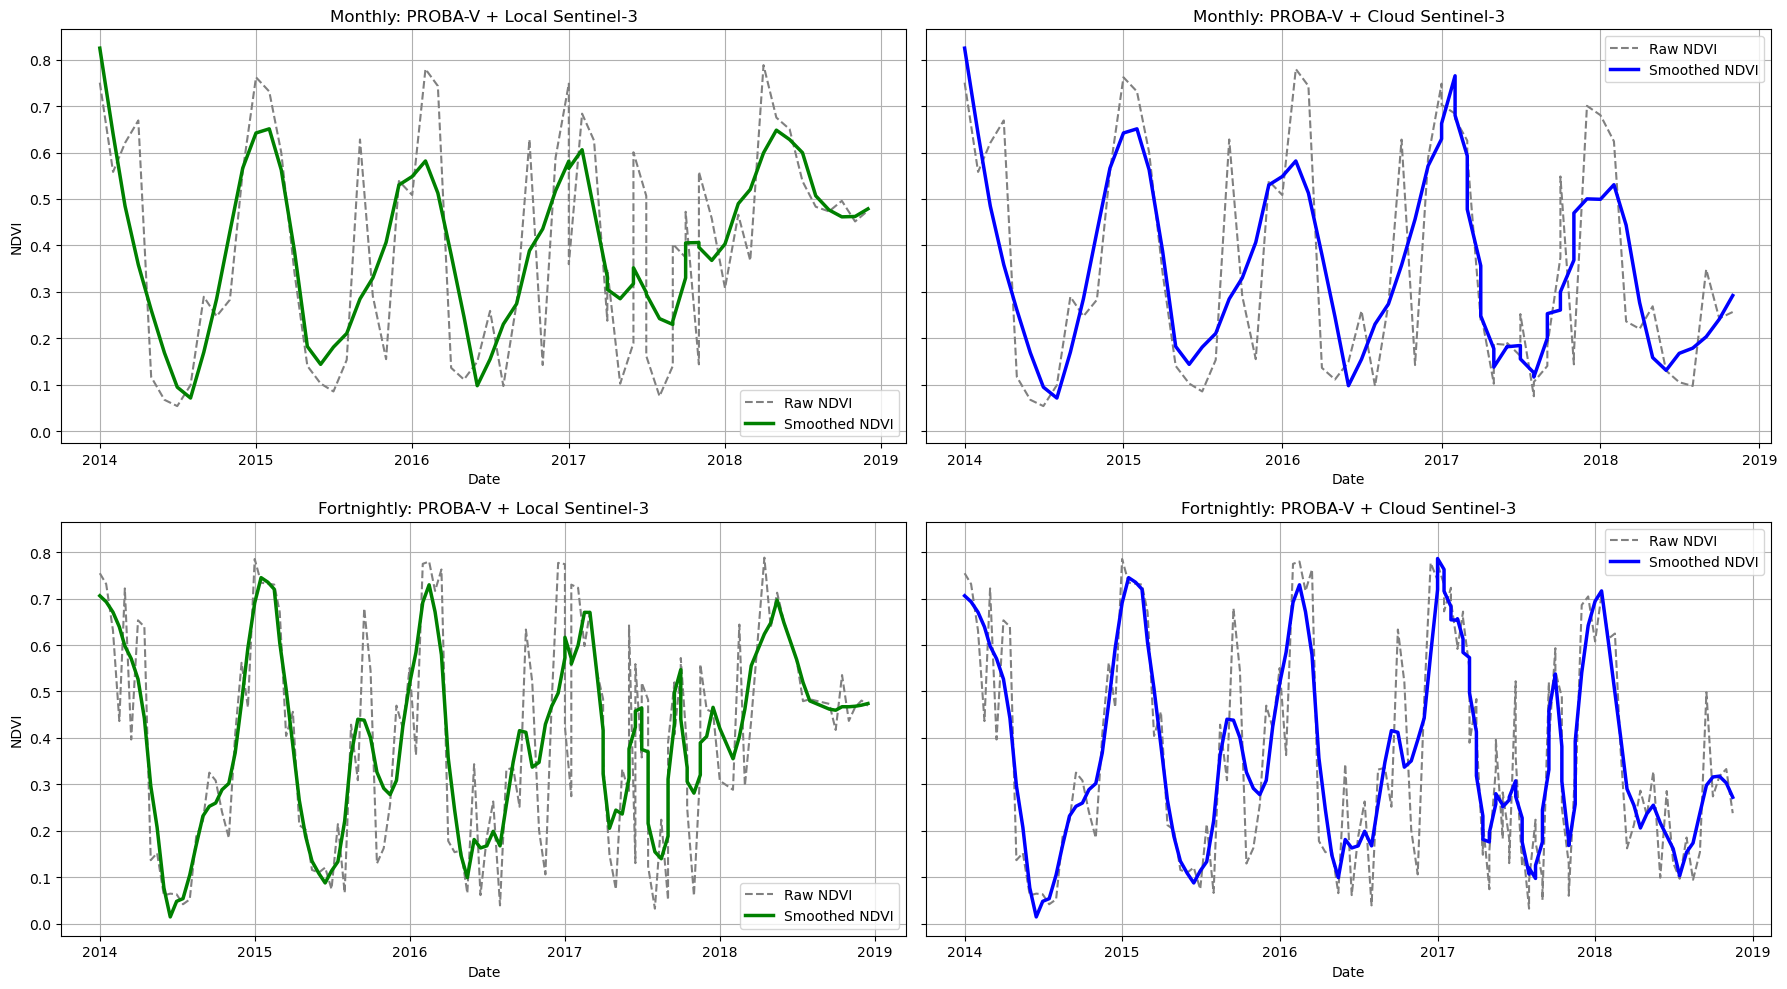

✅ All 4 NDVI charts exported to CSV.


In [15]:
# Smoothing parameters:
# - window_length=9: number of points used in each local regression (must be odd integer, controls smoothing strength)
# - polyorder=2: degree of the polynomial fit (higher = more flexible, but risk of overfitting)
# - mode='interp': handles edge values using interpolation to avoid distortion at the start and end


# === Monthly NDVI Harmonized and Smoothed ===

# Panel 1: PROBA-V + Local Sentinel-3 (Monthly)
all_dates = np.array(proba_dates + s3_dates)
all_ndvis = np.array(proba_ndvis + s3_ndvis)

sort_idx = np.argsort(all_dates)
all_dates = all_dates[sort_idx]
all_ndvis = all_ndvis[sort_idx]

smoothed_ndvi = savgol_filter(all_ndvis, window_length=9, polyorder=2, mode='interp')

# Panel 2: PROBA-V + Cloud Sentinel-3 (Monthly)
all_cloud_dates = np.array(proba_dates + cloud_dates)
all_cloud_ndvis = np.array(proba_ndvis + cloud_ndvis)

sort_idx_cloud = np.argsort(all_cloud_dates)
all_cloud_dates = all_cloud_dates[sort_idx_cloud]
all_cloud_ndvis = all_cloud_ndvis[sort_idx_cloud]

smoothed_cloud_ndvi = savgol_filter(all_cloud_ndvis, window_length=9, polyorder=2, mode='interp')

# === Fortnightly NDVI Harmonized and Smoothed ===

# Panel 3: PROBA-V + Local Sentinel-3 (Fortnightly)
all_dates_fortnite = np.array(proba_dates_fortnite + s3_dates_fortnite)
all_ndvis_fortnite = np.array(proba_ndvis_fortnite + s3_ndvis_fortnite)

sort_idx_fortnite = np.argsort(all_dates_fortnite)
all_dates_fortnite = all_dates_fortnite[sort_idx_fortnite]
all_ndvis_fortnite = all_ndvis_fortnite[sort_idx_fortnite]

smoothed_ndvi_fortnite = savgol_filter(all_ndvis_fortnite, window_length=9, polyorder=2, mode='interp')

# Panel 4: PROBA-V + Cloud Sentinel-3 (Fortnightly)
all_cloud_dates_fortnite = np.array(proba_dates_fortnite + cloud_dates_fortnite)
all_cloud_ndvis_fortnite = np.array(proba_ndvis_fortnite + cloud_ndvis_fortnite)

sort_idx_cloud_fortnite = np.argsort(all_cloud_dates_fortnite)
all_cloud_dates_fortnite = all_cloud_dates_fortnite[sort_idx_cloud_fortnite]
all_cloud_ndvis_fortnite = all_cloud_ndvis_fortnite[sort_idx_cloud_fortnite]

smoothed_cloud_ndvi_fortnite = savgol_filter(all_cloud_ndvis_fortnite, window_length=9, polyorder=2, mode='interp')

# === Plot All Four Panels ===
fig, axs = plt.subplots(2, 2, figsize=(18, 10), sharey=True)

# Monthly Panel 1
axs[0, 0].plot(all_dates, all_ndvis, color='gray', linestyle='--', label='Raw NDVI')
axs[0, 0].plot(all_dates, smoothed_ndvi, color='green', linewidth=2.5, label='Smoothed NDVI')
axs[0, 0].set_title("Monthly: PROBA-V + Local Sentinel-3")
axs[0, 0].set_xlabel("Date")
axs[0, 0].set_ylabel("NDVI")
axs[0, 0].legend()
axs[0, 0].grid(True)

# Monthly Panel 2
axs[0, 1].plot(all_cloud_dates, all_cloud_ndvis, color='gray', linestyle='--', label='Raw NDVI')
axs[0, 1].plot(all_cloud_dates, smoothed_cloud_ndvi, color='blue', linewidth=2.5, label='Smoothed NDVI')
axs[0, 1].set_title("Monthly: PROBA-V + Cloud Sentinel-3")
axs[0, 1].set_xlabel("Date")
axs[0, 1].legend()
axs[0, 1].grid(True)

# Fortnightly Panel 3
axs[1, 0].plot(all_dates_fortnite, all_ndvis_fortnite, color='gray', linestyle='--', label='Raw NDVI')
axs[1, 0].plot(all_dates_fortnite, smoothed_ndvi_fortnite, color='green', linewidth=2.5, label='Smoothed NDVI')
axs[1, 0].set_title("Fortnightly: PROBA-V + Local Sentinel-3")
axs[1, 0].set_xlabel("Date")
axs[1, 0].set_ylabel("NDVI")
axs[1, 0].legend()
axs[1, 0].grid(True)

# Fortnightly Panel 4
axs[1, 1].plot(all_cloud_dates_fortnite, all_cloud_ndvis_fortnite, color='gray', linestyle='--', label='Raw NDVI')
axs[1, 1].plot(all_cloud_dates_fortnite, smoothed_cloud_ndvi_fortnite, color='blue', linewidth=2.5, label='Smoothed NDVI')
axs[1, 1].set_title("Fortnightly: PROBA-V + Cloud Sentinel-3")
axs[1, 1].set_xlabel("Date")
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

# === CSV Export ===

pd.DataFrame({
    "date": all_dates,
    "ndvi": all_ndvis,
    "smoothed_ndvi": smoothed_ndvi
}).to_csv("monthly_probaV_local_s3.csv", index=False)

pd.DataFrame({
    "date": all_cloud_dates,
    "ndvi": all_cloud_ndvis,
    "smoothed_ndvi": smoothed_cloud_ndvi
}).to_csv("monthly_probaV_cloud_s3.csv", index=False)

pd.DataFrame({
    "date": all_dates_fortnite,
    "ndvi": all_ndvis_fortnite,
    "smoothed_ndvi": smoothed_ndvi_fortnite
}).to_csv("fortnightly_probaV_local_s3.csv", index=False)

pd.DataFrame({
    "date": all_cloud_dates_fortnite,
    "ndvi": all_cloud_ndvis_fortnite,
    "smoothed_ndvi": smoothed_cloud_ndvi_fortnite
}).to_csv("fortnightly_probaV_cloud_s3.csv", index=False)

print("✅ All 4 NDVI charts exported to CSV.")